In [32]:
%cd /home/tuyendv/Desktop/reranker/
import json
import pandas as pd
import random

/home/tuyendv/Desktop/reranker


In [33]:
def load_file(path):
    with open(path, "r", encoding="utf-8") as f:
        data = []
        for line in f.readlines():
            json_obj = json.loads(line.strip())
            data.append(json_obj)
    return data

def save_data(path, data):
    with open(path, "w", encoding="utf-8") as f:
        for sample in data:
            json_obj = json.dumps(sample, ensure_ascii=False)
            f.write(json_obj+"\n")

In [34]:
def truncate_passage(passages):
    for i, sample in enumerate(passages):
        words = sample["passage_text"].split(" ")
        if sample["is_selected"] == 1:
            if len(words) > 256:
                return None
            
        else:
            if len(words) > 256:
                random_length = random.randint(224,256)
                start = random.randint(0, len(words) - random_length)
                words=words[start:start+random_length]
        passage_text = " ".join(words)
        
        passages[i]["passage_text"] = passage_text
        
    return passages

In [35]:
path = '/home/tuyendv/Desktop/reranker/data/ir/train/zalo-ai-data.json'
data = load_file(path)
data = pd.DataFrame(data)
data.head()

,query,passages
0,Thủ tướng Trung Quốc là gì,"[{'is_selected': 1, 'passage_text': 'Thủ tướng..."
1,Những cây thánh giá tại ngọn đồi Thánh giá ở L...,"[{'is_selected': 1, 'passage_text': 'Ngọn đồi ..."
2,Lê Duẩn sinh năm bao nhiêu,"[{'is_selected': 1, 'passage_text': 'Cha ông l..."
3,Số lượng sọc đỏ - trắng trên quốc kỳ Mỹ tượng ...,"[{'is_selected': 1, 'passage_text': 'Phía trên..."
4,Hà Nội đã trải qua bao nhiêu lần đổi tên,"[{'is_selected': 1, 'passage_text': 'Ông sinh ..."


In [36]:
data["truncated_passage"] = data.passages.apply(truncate_passage)

In [37]:
def get_length(query, passages):    
    lengths = []
    if passages == None:
        return [0,]
    for pa in passages:
        tmp = pa["passage_text"]
        
        lengths.append(len(tmp.split()))
        
    return lengths

data["truncated_length"] = data.apply(lambda x: get_length(x["query"], x["truncated_passage"]), axis=1)

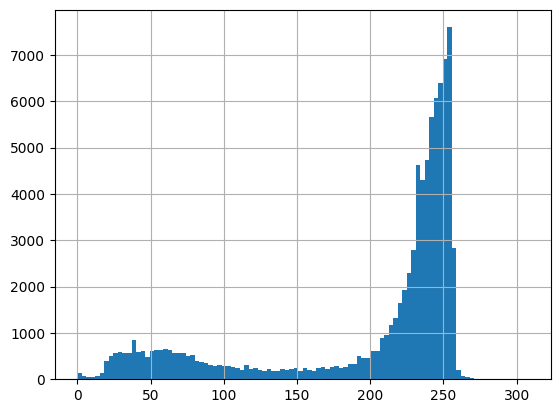

In [38]:
lengths = [i for j in data.truncated_length.tolist() for i in j]
pd.DataFrame(lengths, columns=["lengths"]).lengths.hist(bins=100)

In [39]:
data["selected"] = data.truncated_length.apply(lambda x: 0 if len(x) == 1 else 1)

In [9]:
def convert_to_msmacro_format(data):
    msmacro_data = []
    for index in data.index:
        query = data["query"][index]
        passages = data["truncated_passage"][index]
        
        sample = {
            "query":query,
            "passages":passages
        }
        
        msmacro_data.append(sample)
        
    return msmacro_data

In [10]:
data.head()

,query,passages,truncated_passage,truncated_length,selected
0,In what country is Normandy located?,"[{'is_selected': 1, 'passage_text': 'The Norma...","[{'is_selected': 1, 'passage_text': 'The Norma...","[113, 153, 82, 99, 154, 101, 201, 49]",1
1,When were the Normans in Normandy?,"[{'is_selected': 1, 'passage_text': 'The Norma...","[{'is_selected': 1, 'passage_text': 'The Norma...","[113, 153, 82, 99, 154, 101, 201, 49]",1
2,From which countries did the Norse originate?,"[{'is_selected': 1, 'passage_text': 'The Norma...","[{'is_selected': 1, 'passage_text': 'The Norma...","[113, 153, 82, 99, 154, 101, 201, 49]",1
3,Who was the Norse leader?,"[{'is_selected': 1, 'passage_text': 'The Norma...","[{'is_selected': 1, 'passage_text': 'The Norma...","[113, 153, 82, 99, 154, 101, 201, 49]",1
4,What century did the Normans first gain their ...,"[{'is_selected': 1, 'passage_text': 'The Norma...","[{'is_selected': 1, 'passage_text': 'The Norma...","[113, 153, 82, 99, 154, 101, 201, 49]",1


In [11]:
data[data.selected==1].shape

(11485, 5)

In [12]:
data[data.selected==0].shape

(388, 5)

In [13]:
msmacro_format = convert_to_msmacro_format(data[data.selected==1])

In [14]:
path = "/home/tuyendv/Desktop/reranker/data/processed-ir-data/train/squad-dev-v2.0-en.json"
save_data(path, msmacro_format)

### zalo data

In [30]:
%cd /home/tuyendv/Desktop/reranker/
import json
import pandas as pd
import random
from utils import load_file, save_data
from bm25 import BM25
from tqdm import tqdm
    

/home/tuyendv/Desktop/reranker


In [12]:
bm25 = BM25()

In [4]:
path = "query_passages_overlap=False.json"
data = json.load(open(path, "r", encoding="utf-8"))


In [27]:
ir_data =[]
for sample in tqdm(data):
    query = sample["query"]
    passages = sample["passages"]
    
    positive = None
    contexts = []
    for passage in passages:
        if passage["is_selected"] == 1:
            positive = passage["passage_text"]
        else:
            contexts.append(["temp",passage["passage_text"]])
    contexts = pd.DataFrame(contexts, columns=["id","passage_text"])
    if len(contexts) <= 2:
        continue
    bm25.train(contexts)
    if len(contexts) < 7:
        topk = len(contexts)
    else:
        topk=7
    negatives = bm25.ranking(positive, topk)["retrieval_text"].tolist()
    
    negatives = [
        {
            "is_selected":0,
            "passage_text":neg
            } 
        for neg in negatives]
    positive = {
        "is_selected":1,
        "passage_text":positive
    }
    
    passages = [positive,]+negatives
    
    ir_data.append(
        {
            "query":query,
            "passages":passages
            }
    )    

100%|██████████| 15557/15557 [03:40<00:00, 70.56it/s] 


In [28]:
len(ir_data)

12091

In [31]:
path = "/home/tuyendv/Desktop/reranker/data/ir/train/zalo-ai-data.json"
save_data(path, ir_data)